# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

preselection_sample library virus_batch  replicate  \
0   2021-10-28_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
1   2021-10-28_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
2   2021-10-28_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
3   2021-10-28_thaw-1_VSVG_control_2   Lib-3      thaw-1          2   
4   2021-10-28_thaw-1_VSVG_control_1   Lib-4      thaw-1          1   
5   2021-10-28_thaw-1_VSVG_control_2   Lib-4      thaw-1          2   
6   2021-10-28_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
7   2021-10-28_thaw-1_VSVG_control_2   Lib-2      thaw-1          2   
8   2022-03-25_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
9   2022-03-25_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
10  2022-06-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
11  2022-06-22_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
12  2022-10-22_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
13  2022-10-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
14  2022-10-22_thaw-2_VSVG_control_1   Lib-1      thaw-2          2   
15  2022-10-22_thaw-2_VSVG_control_1   Lib-2      thaw-2          2   

                       postselection_sample  \
0   2021-12-14_thaw-1_no-antibody_control_1   
1   2021-12-14_thaw-1_no-antibody_control_2   
2   2021-12-14_thaw-1_no-antibody_control_1   
3   2021-12-14_thaw-1_no-antibody_control_2   
4   2021-12-14_thaw-1_no-antibody_control_1   
5   2021-12-14_thaw-1_no-antibody_control_2   
6   2021-11-28_thaw-1_no-antibody_control_1   
7   2021-11-28_thaw-1_no-antibody_control_2   
8   2022-04-13_thaw-1_no-antibody_control_1   
9   2022-04-13_thaw-1_no-antibody_control_2   
10  2022-06-22_thaw-1_no-antibody_control_1   
11  2022-06-22_thaw-1_no-antibody_control_1   
12  2022-10-22_thaw-1_no-antibody_control_1   
13  2022-10-22_thaw-1_no-antibody_control_1   
14  2022-10-22_thaw-2_no-antibody_control_1   
15  2022-10-22_thaw-2_no-antibody_control_1   

               preselection_library_sample  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2   
4   Lib-4_2021-10-28_thaw-1_VSVG_control_1   
5   Lib-4_2021-10-28_thaw-1_VSVG_control_2   
6   Lib-2_2021-10-28_thaw-1_VSVG_control_1   
7   Lib-2_2021-10-28_thaw-1_VSVG_control_2   
8   Lib-1_2022-03-25_thaw-1_VSVG_control_1   
9   Lib-1_2022-03-25_thaw-1_VSVG_control_2   
10  Lib-2_2022-06-22_thaw-1_VSVG_control_1   
11  Lib-3_2022-06-22_thaw-1_VSVG_control_1   
12  Lib-1_2022-10-22_thaw-1_VSVG_control_1   
13  Lib-2_2022-10-22_thaw-1_VSVG_control_1   
14  Lib-1_2022-10-22_thaw-2_VSVG_control_1   
15  Lib-2_2022-10-22_thaw-2_VSVG_control_1   

                     postselection_library_sample  \
0   Lib-1_2021-12-14_thaw-1_no-antibody_control_1   
1   Lib-1_2021-12-14_thaw-1_no-antibody_control_2   
2   Lib-3_2021-12-14_thaw-1_no-antibody_control_1   
3   Lib-3_2021-12-14_thaw-1_no-antibody_control_2   
4   Lib-4_2021-12-14_thaw-1_no-antibody_control_1   
5   Lib-4_2021-12-14_thaw-1_no-antibody_control_2   
6   Lib-2_2021-11-28_thaw-1_no-antibody_control_1   
7   Lib-2_2021-11-28_thaw-1_no-antibody_control_2   
8   Lib-1_2022-04-13_thaw-1_no-antibody_control_1   
9   Lib-1_2022-04-13_thaw-1_no-antibody_control_2   
10  Lib-2_2022-06-22_thaw-1_no-antibody_control_1   
11  Lib-3_2022-06-22_thaw-1_no-antibody_control_1   
12  Lib-1_2022-10-22_thaw-1_no-antibody_control_1   
13  Lib-2_2022-10-22_thaw-1_no-antibody_control_1   
14  Lib-1_2022-10-22_thaw-2_no-antibody_control_1   
15  Lib-2_2022-10-22_thaw-2_no-antibody_control_1   

                                       selection_name  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
4   Lib-4_2021-10-28_thaw-1_VSVG_contro

**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [3]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : 5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.1-2",
    "conditions" : [
#         "Delta-2", "Delta-3",
        "Omicron_BA.1-2",# "Omicron_BA.1-3", #,
        "Omicron_BA.2-1"# "Omicron_BA.2-2"
    ]
}

In [4]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [5]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

preselection_sample library virus_batch  replicate  \
10  2022-06-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
12  2022-10-22_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
14  2022-10-22_thaw-2_VSVG_control_1   Lib-1      thaw-2          2   

                       postselection_sample  \
10  2022-06-22_thaw-1_no-antibody_control_1   
12  2022-10-22_thaw-1_no-antibody_control_1   
14  2022-10-22_thaw-2_no-antibody_control_1   

               preselection_library_sample  \
10  Lib-2_2022-06-22_thaw-1_VSVG_control_1   
12  Lib-1_2022-10-22_thaw-1_VSVG_control_1   
14  Lib-1_2022-10-22_thaw-2_VSVG_control_1   

                     postselection_library_sample  \
10  Lib-2_2022-06-22_thaw-1_no-antibody_control_1   
12  Lib-1_2022-10-22_thaw-1_no-antibody_control_1   
14  Lib-1_2022-10-22_thaw-2_no-antibody_control_1   

                                       selection_name  \
10  Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...   
12  Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...   
14  Lib-1_2022-10-22_thaw-2_VSVG_control_1_vs_2022...   

                                             filename  \
10  ../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...   
12  ../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...   
14  ../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...   

                                   func_sel_scores_df  len_func_sel_scores_df  \
10         library                        pre_samp...                  140643   
12        library                        pre_sampl...                   90992   
14        library                        pre_sampl...                   90992   

         homolog       condition  
10  Omicron_BA.1  Omicron_BA.1-2  
12  Omicron_BA.2  Omicron_BA.2-1  
14  Omicron_BA.2  Omicron_BA.2-1

In [6]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

library                        pre_sample  \
0   Lib-2  2022-06-22_thaw-1_VSVG_control_1   
1   Lib-2  2022-06-22_thaw-1_VSVG_control_1   
2   Lib-2  2022-06-22_thaw-1_VSVG_control_1   
3   Lib-2  2022-06-22_thaw-1_VSVG_control_1   
4   Lib-2  2022-06-22_thaw-1_VSVG_control_1   

                               post_sample           barcode  func_score  \
0  2022-06-22_thaw-1_no-antibody_control_1  TGATTCGCACCCTCGG     -0.1131   
1  2022-06-22_thaw-1_no-antibody_control_1  AGCCCGCCGCGAAAAA     -1.0064   
2  2022-06-22_thaw-1_no-antibody_control_1  CCCACCAAACAGAACA     -0.0414   
3  2022-06-22_thaw-1_no-antibody_control_1  TGTATGTAAATGTCAG     -1.1616   
4  2022-06-22_thaw-1_no-antibody_control_1  CAGAATCAATAGCAGA     -0.4821   

   func_score_var  pre_count  post_count  pre_count_wt  post_count_wt  \
0          0.0005       7252        8303      11338665       14040452   
1          0.0009       6152        3792      11338665       14040452   
2          0.0007       5486        6601      11338665       14040452   
3          0.0011       5245        2903      11338665       14040452   
4          0.0009       5190        4601      11338665       14040452   

   pseudocount  n_codon_substitutions aa_substitutions_sequential  \
0          0.5                      4    D212P D250N H951A N1122H   
1          0.5                      2                         NaN   
2          0.5                      0                         NaN   
3          0.5                      2                        N97D   
4          0.5                      1                       Y446H   

   n_aa_substitutions          aa_substitutions  pre_count_threshold  \
0                   4  D215P D253N H954A N1125H                   66   
1                   0                       NaN                   66   
2                   0                       NaN                   66   
3                   1                      N99D                   66   
4                   1                     Y449H                   66   

        homolog  replicate       condition  
0  Omicron_BA.1          1  Omicron_BA.1-2  
1  Omicron_BA.1          1  Omicron_BA.1-2  
2  Omicron_BA.1          1  Omicron_BA.1-2  
3  Omicron_BA.1          1  Omicron_BA.1-2  
4  Omicron_BA.1          1  Omicron_BA.1-2

**Optionally subset the variants**

In [7]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [8]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [9]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 4836 variants, 573 had fewer than 100 counts before selection, and were filtered out


In [10]:
func_score_df

library                        pre_sample  \
241122   Lib-1  2022-10-22_thaw-2_VSVG_control_1   
38369    Lib-2  2022-06-22_thaw-1_VSVG_control_1   
146015   Lib-1  2022-10-22_thaw-1_VSVG_control_1   
303062   Lib-1  2022-10-22_thaw-2_VSVG_control_1   
6829     Lib-2  2022-06-22_thaw-1_VSVG_control_1   
...        ...                               ...   
152246   Lib-1  2022-10-22_thaw-1_VSVG_control_1   
11801    Lib-2  2022-06-22_thaw-1_VSVG_control_1   
11234    Lib-2  2022-06-22_thaw-1_VSVG_control_1   
297837   Lib-1  2022-10-22_thaw-2_VSVG_control_1   
231744   Lib-1  2022-10-22_thaw-2_VSVG_control_1   

                                    post_sample           barcode  func_score  \
241122  2022-10-22_thaw-2_no-antibody_control_1  GTAACGCTTGAACTTG     -1.6640   
38369   2022-06-22_thaw-1_no-antibody_control_1  ATAGTAAGATTATGCT      0.3868   
146015  2022-10-22_thaw-1_no-antibody_control_1  ACCTTTCATCCTTCAT     -0.0789   
303062  2022-10-22_thaw-2_no-antibody_control_1  CAACAAAGCAGGGCCA     -6.7790   
6829    2022-06-22_thaw-1_no-antibody_control_1  AAAAATTAGTCCCATT     -0.5982   
...                                         ...               ...         ...   
152246  2022-10-22_thaw-1_no-antibody_control_1  CACACGGAATAGGATC     -0.0410   
11801   2022-06-22_thaw-1_no-antibody_control_1  CCCACCGAACTCTATA      0.1525   
11234   2022-06-22_thaw-1_no-antibody_control_1  CTTCAAGAGTACAACC     -1.0683   
297837  2022-10-22_thaw-2_no-antibody_control_1  CCGTACACGTCAACTG     -0.4299   
231744  2022-10-22_thaw-2_no-antibody_control_1  TCCTAAGATGACCTCG      0.4079   

        func_score_var  pre_count  post_count  pre_count_wt  post_count_wt  \
241122          0.0145       1153         164       5160038        2331953   
38369           0.0059        573         928      11338665       14040452   
146015          0.0022       1888        1917       7350522        7882877   
303062          4.1799        121           0       5160038        2331953   
6829            0.0035       1318        1078      11338665       14040452   
...                ...        ...         ...           ...            ...   
152246          0.0031       1298        1353       7350522        7882877   
11801           0.0033       1073        1477      11338665       14040452   
11234           0.0051       1096         647      11338665       14040452   
297837          0.0529        156          52       5160038        2331953   
231744          0.0012       4570        2740       5160038        2331953   

        pseudocount  n_codon_substitutions aa_substitutions_sequential  \
241122          0.5                      3         N402E V1057C Q1139L   
38369           0.5                      0                         NaN   
146015          0.5                      3                V140T G1243D   
303062          0.5                      4    F154V P370A S688F A1013T   
6829            0.5                      0                         NaN   
...             ...                    ...                         ...   
152246          0.5                      0                         NaN   
11801           0.5                      4      N72H N85H D173N K1188D   
11234           0.5                      1                       L171S   
297837          0.5                      1                        T22A   
231744          0.5                      4           L115V T729A H951T   

        n_aa_substitutions          aa_substitutions  pre_count_threshold  \
241122                   3       N405E V1060C Q1142L                   46   
38369                    0                                             66   
146015                   2              V143T G1246D                   59   
303062                   4  F157V P373A S691F A1016T                   46   
6829                     0                                             66   
...                    ...                       ...                  ...   
152246                   0                  

**Optionally, scale the counts**

In [11]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [12]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [13]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [14]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [15]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [16]:
# func_score_df.to_csv("Delta_BA1_BA2_func_score_df.csv")

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [17]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [18]:
# datasets

In [19]:
# tqdm.pandas()
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition']#,
#     collapse_identical_variants=True
)

  0%|          | 0/1449 [00:00<?, ?it/s]

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [21]:
datasets = pd.DataFrame()

In [22]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

scale_counts min_pre_counts pseudocount sample  clip_target   trim  \
0        False            100         0.1   5000  (-3.5, 2.5)  False   

  reference_condition                        conditions  \
0      Omicron_BA.1-2  [Omicron_BA.1-2, Omicron_BA.2-1]   

                                                data  
0  <multidms.data.MultiDmsData object at 0x7fa83d...

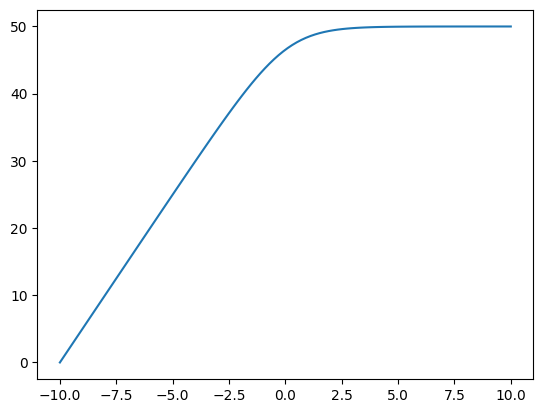

In [23]:
import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [24]:
datasets

scale_counts min_pre_counts pseudocount sample  clip_target   trim  \
0        False            100         0.1   5000  (-3.5, 2.5)  False   

  reference_condition                        conditions  \
0      Omicron_BA.1-2  [Omicron_BA.1-2, Omicron_BA.2-1]   

                                                data  
0  <multidms.data.MultiDmsData object at 0x7fa83d...

In [25]:
datasets.loc[0, "data"].site_map.loc[[95, 142], :]

Omicron_BA.1-2 Omicron_BA.2-1
95               I              T
142              D              D

In [30]:
datasets.loc[0, "data"].non_identical_mutations

frozendict.frozendict({'Omicron_BA.2-1': 'R408S S446G F981L A27S K856N L371F I212L S496G D405N K547T I95T V67A T376A T19I V213G', 'Omicron_BA.1-2': ''})

In [27]:
# datasets.loc[3, "data"]._collapse_identical_variants

## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [28]:
# un-comment to re-initialize results
models = defaultdict(list)

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [29]:
import multidms.model as model
for dataset in [0]:
    for ge_func in [model.sigmoidal_global_epistasis]:
        for output_act in [model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=10
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 18 seconds


model  dataset
0  <multidms.model.MultiDmsModel object at 0x7fa6...        0

In [104]:
cc

{'Delta-2': (0.7490196078431373, 0.7490196078431373, 0.7490196078431373),
 'Delta-3': (0.25098039215686274, 0.25098039215686274, 0.25098039215686274),
 'Omicron_BA.1-2': (0.9764705882352941,
  0.45098039215686275,
  0.023529411764705882),
 'Omicron_BA.1-3': (1.0, 0.6470588235294118, 0.0),
 'Omicron_BA.2-1': (0.5803921568627451, 0.0, 0.8274509803921568),
 'Omicron_BA.2-2': (0.9333333333333333,
  0.5098039215686274,
  0.9333333333333333)}

### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [125]:
import matplotlib.colors as colors

palette = [
    '#BFBFBF','#404040',
    '#F97306', '#FFA500',
    '#9400D3', '#EE82EE',
]

conditions = sorted(datasets.loc[0, "data"].conditions)
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
for row, values in datasets.iterrows():
    values.data.condition_colors = cc

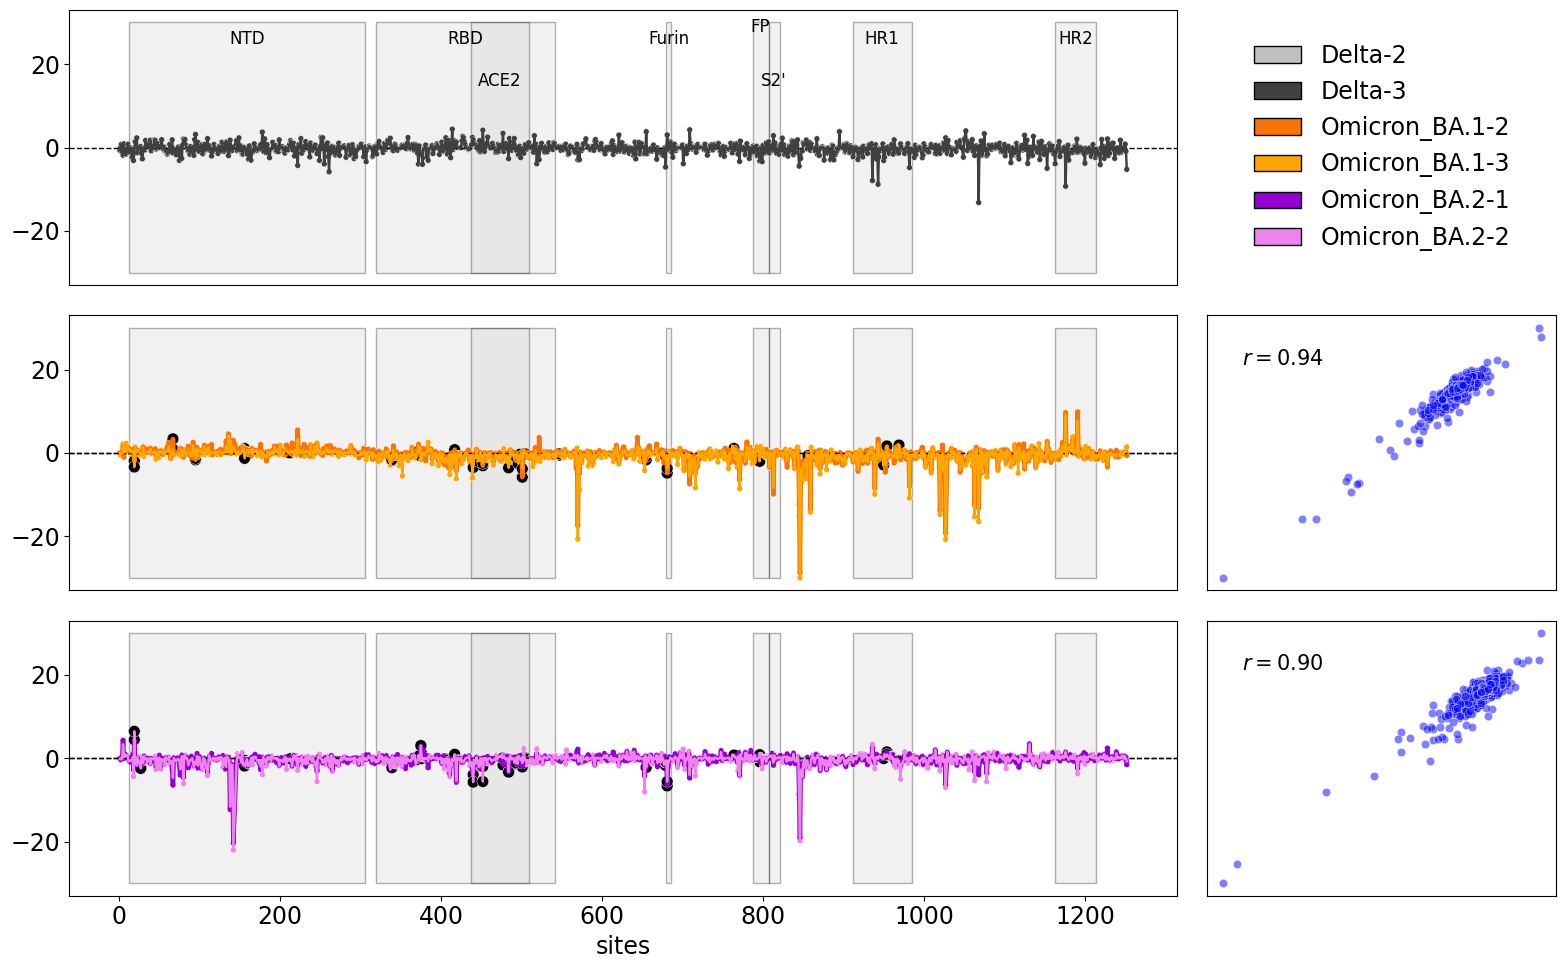

In [133]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 17})

#         aceX
for model in [0]:
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    axd = fig.subplot_mosaic(
        """
        bbbg
        dddh
        fffi
        """,
        empty_sentinel="X",
        gridspec_kw={ 
        }
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }
    
    moi = models_df.loc[model, "model"]

    facet_groups = {
        ("b", "g") : ("Delta-2", "Delta-3"),
        ("d", "h") : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        ("f", "i") : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi[0]].add_patch(rect_v)
        for r, condition in enumerate(facet_group):
            
            if condition == moi.data.reference: continue
            lw=3.25 if r == 0 else 1.75
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi[0]],
                lw=lw

            )
        axd[axi[0]].set_ylabel("")
        
        if moi.data.reference not in facet_group:          
            from scipy.stats import pearsonr
            
            mut_df = moi.mutation_site_summary_df(agg_func=onp.sum, times_seen_threshold=3)
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="blue"
                
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.82),
                xycoords="axes fraction", fontsize=15, color="black"
            )
            
#             legend_elements = [
# #                 patches.Patch(
# #                      facecolor="black", 
# #                      edgecolor="black", 
# #                      label="all muts"
# #                 ),
#                 patches.Patch(
#                     facecolor="blue", 
#                     edgecolor="black", 
#                     label="$\sum$" #_{m \in site}s_{m,d}$"
#                 )
                
#             ]
#             axd[axi[1]].legend(
#                     handles=legend_elements, 
#                     loc="lower right",
#                     frameon=False,
#                     fontsize=12
#             )
            
#             mut_df = moi.mutations_df
            
#             times_seen_cols = [c for c in mut_df.columns if "times" in c]
#             for c in times_seen_cols:
#                 mut_df = mut_df[mut_df[c]>=3]
                
#             x = mut_df[f"S_{facet_group[0]}"].values
#             y = mut_df[f"S_{facet_group[1]}"].values
#             r = pearsonr(x, y)[0]
#             sns.scatterplot(mut_df,
#                 x=f"S_{facet_group[0]}",
#                 y=f"S_{facet_group[1]}", 
#                 ax=axd[axi[1]],
#                 alpha=0.5,
#                 color="black"
#             )
#             axd[axi[1]].annotate(
#                 f"$r = {r:.2f}$", (0.1, 0.9),
#                 xycoords="axes fraction", fontsize=12, color="black"
#             )
            axd[axi[1]].get_xaxis().set_visible(False)
            axd[axi[1]].get_yaxis().set_visible(False)
            
        
                 
        else:
            
            axd[axi[1]].axis('off')
            
#             conditions = sorted(moi.data.conditions)
#             cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
            legend_elements = [
                patches.Patch(
                     facecolor=col, 
                     edgecolor="black", 
                     label=con
                )
                for con, col in cc.items()
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="center",
                    frameon=False
            )
            
    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}" #": \n{start}-{end}"
        ycoord = 26
        if pr in ["ACE2", "S2'"]:
            ycoord = 16
        if pr in ["FP"]:
            ycoord = 29

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=12, rotation=0)

    axd["b"].get_xaxis().set_visible(False)
    axd["d"].get_xaxis().set_visible(False)
    

#     fig.text(0.00, 0.5, "$\sum_{m \in site}s_{m,d}$", va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f"shifts_reference_{moi.data.reference}.png")

In [104]:
# for m in [0, 1]:
#     model = models_df.loc[m, "model"]
#     chart = model.mut_shift_plot()
#     chart.save(f"altair-chart-{m}.html")

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


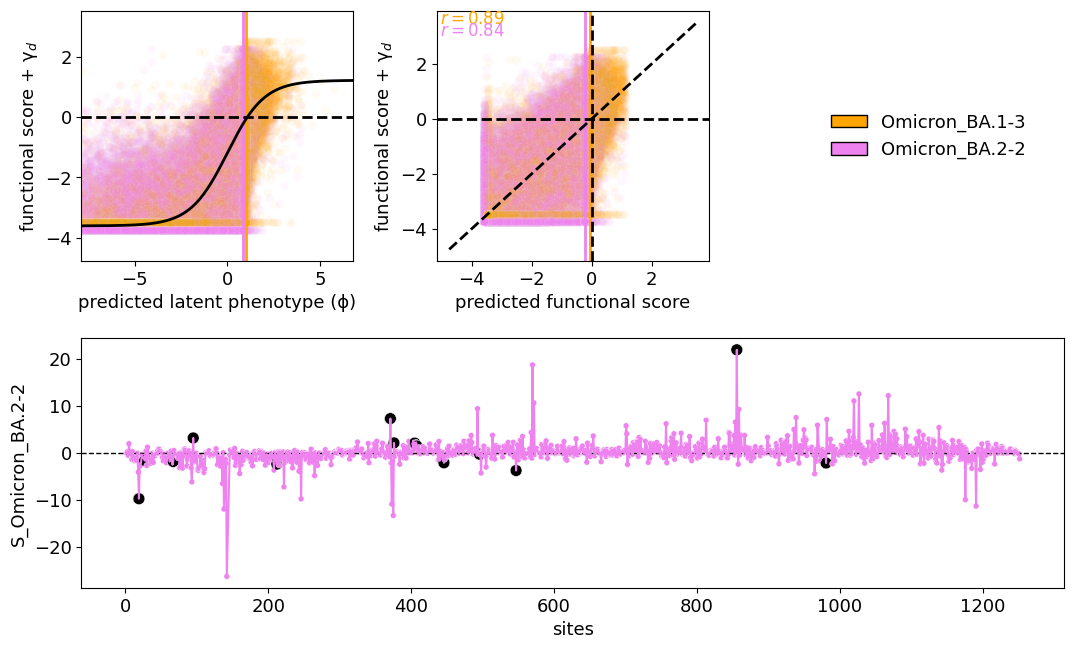

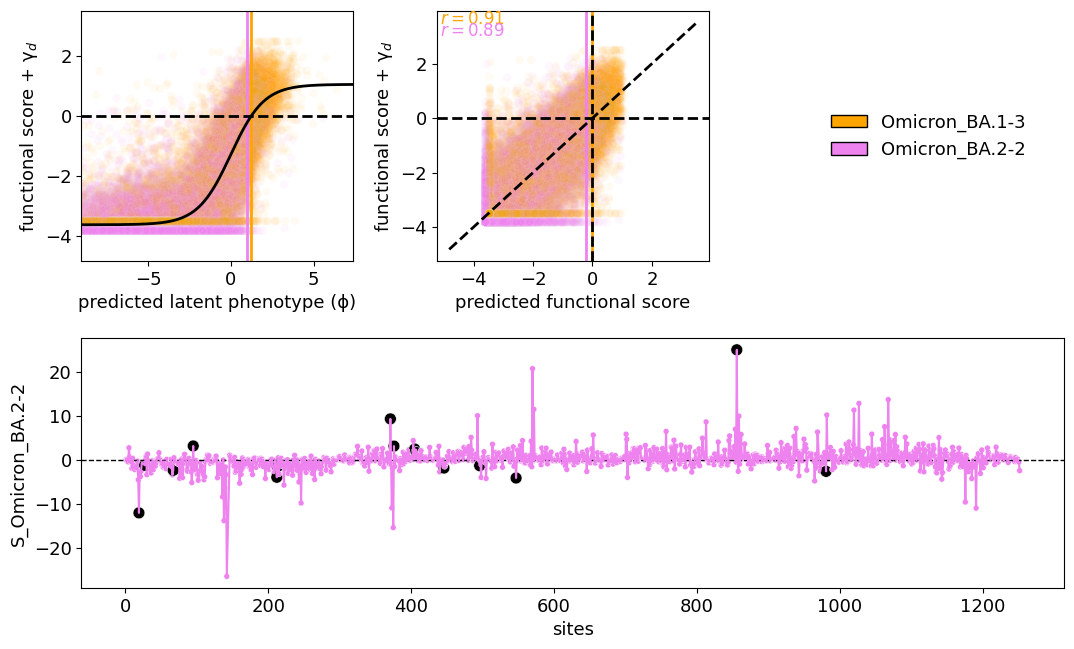

In [134]:
%matplotlib inline
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 13})

for m in [4,6]:
    model = models_df.loc[m, "model"]
#     conditions = sorted(model.data.conditions)
#     cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

    fig = plt.figure(constrained_layout=True, figsize=[11,6.5])
    axd = fig.subplot_mosaic(
        """
        ABC
        DDD
        """,
        empty_sentinel="X"
    )
    non_ref_cond = list(set(model.data.conditions) - set([model.data.reference]))[0]
#     print(non_ref_cond)
#     print(non_ref_cond)
#     continue
    
    model.plot_epistasis(ax=axd["A"], alpha=0.05, show=False, legend=False)
    model.plot_pred_accuracy(ax=axd["B"], alpha=0.05, show=False, legend=False)
    model.plot_shifts_by_site(non_ref_cond, show=False, ax=axd["D"], agg_func=onp.sum)
    
    conditions = sorted(model.data.conditions)
#     cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
    axd["C"].axis('off')
    legend_elements = [
        patches.Patch(
             facecolor=cc[cond], 
             edgecolor="black", 
             label=cond
        )
        for cond in conditions
    ]

    axd["C"].legend(
            handles=legend_elements, 
            loc='center',#, bbox_to_anchor=(1, 0.5),
            frameon=False
    )

    plt.show()
#     break

In [135]:
models_df.loc[0, "model"].mut_shift_plot()

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [136]:
models_df.loc[6, "model"].mut_shift_plot()

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)